<a href="https://colab.research.google.com/github/CareerHeroes/X-Ray-Pneumonia-Detection/blob/master/X_Ray_pneumonia_detection%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
In this example we are going to use transfer learning to detect pneumonia in x-ray images. In order to achieve this we will retrain the inception 3 image classifier on a pneumonia dataset using Tensorflow and Keras.

# Step 1: Get the data set from Kaggle

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'XXXXX'
os.environ['KAGGLE_KEY'] = 'YYYYY'

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:41<00:00, 13.9MB/s]
100% 2.29G/2.29G [00:41<00:00, 59.0MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

# Step 2: Checking if the data / images is loaded correctly

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

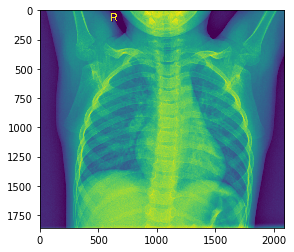

In [0]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

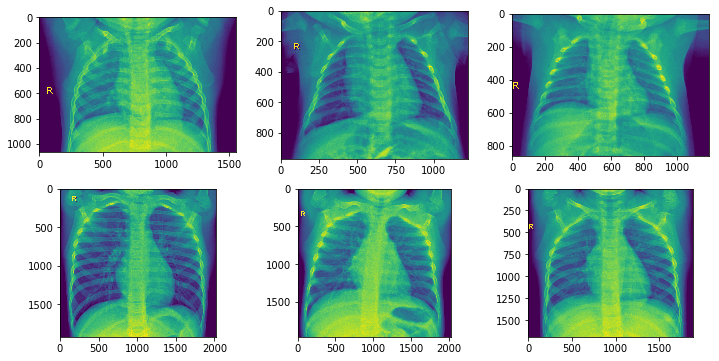

In [0]:
plot_images(training_dir + '/NORMAL')

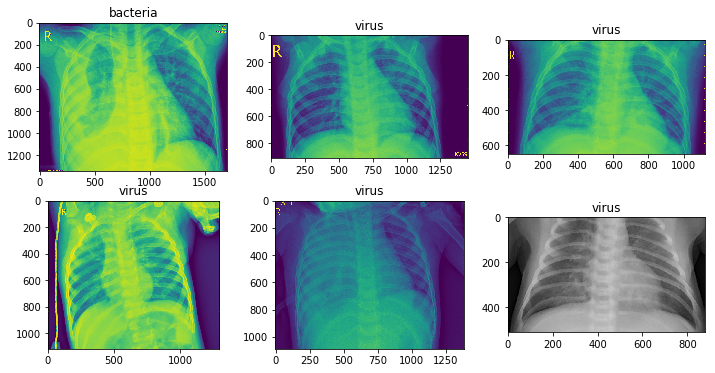

In [0]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

# Step 3: Re-Training the inception3 image classifier 

In [0]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

In [0]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [0]:
model = get_model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_191 (BatchN (None, None, None, 3 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_191[0][0]    
____________________________________________________________________________________________

In [0]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 329s 2s/step - loss: 0.3760 - acc: 0.8637 - val_loss: 1.5001 - val_acc: 0.6587
Epoch 2/5
163/163 [==============================] - 323s 2s/step - loss: 0.2630 - acc: 0.8955 - val_loss: 4.5657 - val_acc: 0.6266
Epoch 3/5
163/163 [==============================] - 322s 2s/step - loss: 0.2736 - acc: 0.8894 - val_loss: 1.3904 - val_acc: 0.6891
Epoch 4/5
163/163 [==============================] - 322s 2s/step - loss: 0.2590 - acc: 0.8898 - val_loss: 1.3417 - val_acc: 0.7003
Epoch 5/5
163/163 [==============================] - 326s 2s/step - loss: 0.2420 - acc: 0.9030 - val_loss: 0.9404 - val_acc: 0.7115


# Step 4: Evaluating the model

In [0]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 87ms/step
Loss: 1.4039658493606169
Accuracy: 0.75


In [0]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results
16/16 [==============================] - 4s 237ms/step


In [54]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

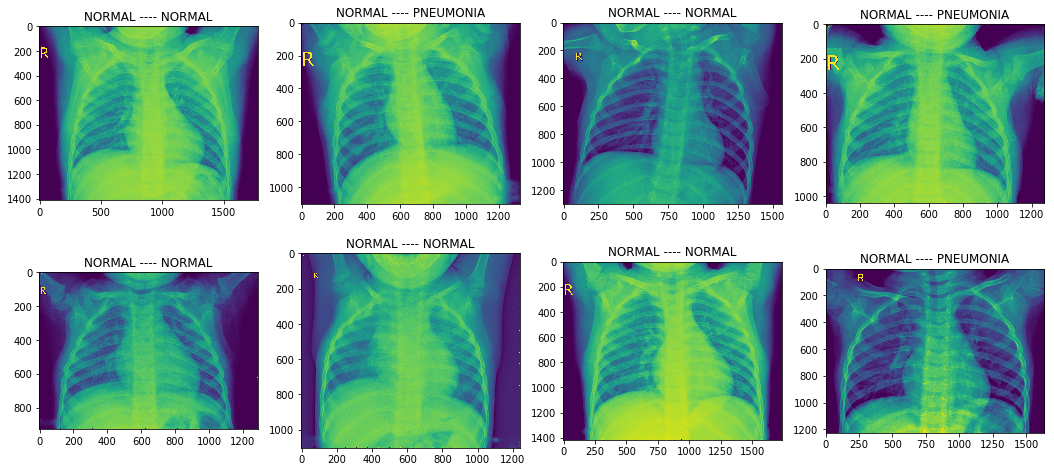

In [55]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

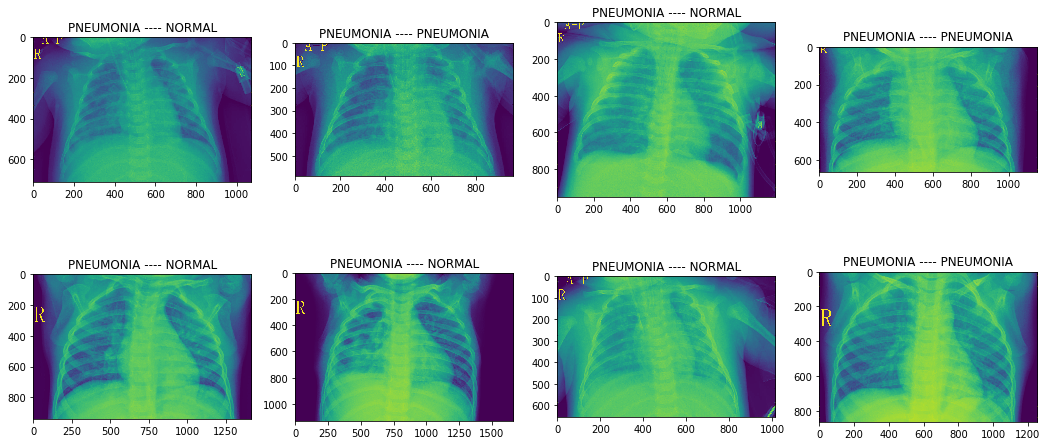

In [56]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

In [0]:
model.save('Inception_meets_pneumonia.h5')